In [1]:
from pathlib import Path

import numpy as np
import torch

from tqdm.auto import tqdm

import itertools

import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(), verbose=True)

True

# prepare data

In [3]:
from src.utils.ensemble import optimize_val_correlation
from src.config.config import combine_cfgs, get_cfg_defaults
from src.data.datamodule import MyDataModule
from pathlib import Path
import torch
import numpy as np

In [10]:
# prepare train and validation data
cfg = get_cfg_defaults()
cfg.DATASET.TRANSFORM = 'i3d_flow'
cfg.DATASET.FRAMES = 64
dm = MyDataModule(cfg)
dm.prepare_data()
dm.setup()

val_indices = dm.val_dataset.indices
fmris_cache_path = Path('/data/huze/.cache/trainval_fmris.pt')

if fmris_cache_path.exists():
    fmris = torch.load(fmris_cache_path)
else:
    fmris = [dm.dataset_train_val.__getitem__(i)[1]
             for i in tqdm(range(dm.dataset_train_val.__len__()))]
    fmris = np.stack(fmris, 0)
    fmris = torch.tensor(fmris)
    torch.save(fmris, fmris_cache_path)

val_fmris = fmris[val_indices]

In [11]:
num_videos = len(dm.dataset_train_val)

In [12]:
print(dm.dataset_train_val.__getitem__(0)[0].shape)

(2, 64, 224, 224)


In [13]:
chaotic_motions = []
vector_motions = []
for vid_idx in tqdm(range(num_videos)):
    flow_vid, fmri = dm.dataset_train_val.__getitem__(vid_idx)
    vector_motions.append(flow_vid.sum(-1).sum(-1).sum(-1))
    chaotic_motions.append(np.sqrt((flow_vid**2).sum(0)).sum())
chaotic_motions = np.asarray(chaotic_motions)
vector_motions = np.asarray(vector_motions)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
chaotic_motions.shape

(1000,)

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

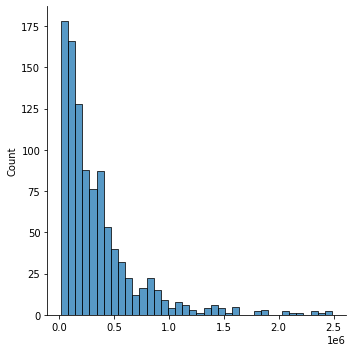

In [16]:
sns.displot(chaotic_motions)
plt.show()

In [17]:
np.save('tmp/notebook920/chaotic_motion.npy', chaotic_motions)